In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

import nltk
from nltk import PorterStemmer

PS = PorterStemmer()

In [4]:
from jpstemmer import JPStemmer

JPS = JPStemmer()

In [39]:
from sklearn.mixture import GaussianMixture

In [140]:
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances

In [167]:
import matplotlib.pyplot as plt

## Constant variables

In [5]:
DATA_PATH = "liquor_data_new.csv"

In [6]:
FLAVOUR_COLUMNS = ["f1", "f2", "f3", "f4", "f5", "f6"]

## Data exploration

In [7]:
def load_data(data_path):
    return pd.read_csv(data_path, sep="\t", encoding='utf-8')

In [8]:
df_initial = load_data(DATA_PATH)

In [9]:
df_initial.head()

,name,intl_name,brand_name,brand_intl_name,year_month,rank,score,f1,f2,f3,f4,f5,f6,flavour_tags,checkin_count,pictures,similar_brands,id,similar_brand_taste
0,上川大雪,Kamikawataisetsu,北海道,Hokkaido,202001,1,4.299969,0.516103,0.484763,0.203029,0.419481,0.276085,0.453028,|グイグイ|メロン|フレッシュ|上品|丸み|フルーティ|旨味|甘味|酸味|マスカット|ガス|...,117,https://s3-ap-northeast-1.amazonaws.com/physal...,加茂錦|而今|陸奥八仙|宮寒梅|十四代,8685,上川大雪|東洋美人|十四代|冩楽|笑四季|Ohmine Junmai|川中島|豊明|至|一白水成
1,國稀,Kunimare,北海道,Hokkaido,202001,2,4.099463,0.187750,0.304858,0.417155,0.539935,0.527491,0.357793,|辛口|蜜|スッキリ|力強い|旨味|ゴクゴク|洋梨|若い|じっくり|薄い|円やか|ちびちび|...,210,https://s3-ap-northeast-1.amazonaws.com/physal...,月山|黒牛|龍力|谷川岳|春鹿,1928,國稀|黎明|越前岬|鷹来屋|宮の雪|初孫|住吉|春鶯囀|長良川|辰泉
2,男山,Otokoyama,北海道,Hokkaido,202001,3,4.095614,0.277607,0.394435,0.327092,0.520835,0.454270,0.427476,|辛口|酸味|甘味|旨味|スッキリ|冷酒|常温|ヨーグルト|ヤクルト|熱燗|ひろがる|バラン...,397,https://s3-ap-northeast-1.amazonaws.com/physal...,春鹿|まんさくの花|酔鯨|加賀鳶|いづみ橋,2,男山|八海山|喜楽長|杉勇|神聖|大那|如空|千代むすび|七冠馬|白隠正宗
3,国士無双,Kokushimuso,北海道,Hokkaido,202001,4,4.079436,0.387998,0.256487,0.161930,0.372511,0.593511,0.516169,|辛口|洋梨|ピリリ|フルーティ|荒々しい|スパイシー|さらり|果物|酸味|さわやか|スイス...,208,https://s3-ap-northeast-1.amazonaws.com/physal...,上喜元|酔心|澤乃井|加賀鳶|司牡丹,10,国士無双|真野鶴|無想|藍の郷|あら玉|福祝|幻の瀧|高清水|きりんざん|北光正宗
4,北の錦,Kitanonishiki,北海道,Hokkaido,202001,5,4.055023,0.344262,0.393210,0.501239,0.564264,0.211910,0.335154,|とろみ|荒々しい|力強い|ほのか|薄い|トロピカル|ヨーグルト|濃厚|苦味|チーズ|旨味|...,85,https://s3-ap-northeast-1.amazonaws.com/physal...,誠鏡|原田|龍力|旦|天の戸,11,北の錦|爛漫|木戸泉|松みどり|芳水|千福|玉櫻|磐城壽|豊久仁|喜久酔


In [10]:
tab_infor = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
tab_infor = tab_infor.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: "Nunber of null records"}))
tab_infor

,name,intl_name,brand_name,brand_intl_name,year_month,rank,score,f1,f2,f3,f4,f5,f6,flavour_tags,checkin_count,pictures,similar_brands,id,similar_brand_taste
column type,object,object,object,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,object,int64,object,object,int64,object
Nunber of null records,0,144,0,0,0,0,0,326,326,326,326,326,326,19,0,1,126,0,326


## Data cleaning

In [11]:
brand_nan = []

In [12]:
def get_brand_nan(df):
    brand_nan = []
    
    for idx, row in df.iterrows():
        similar_brand_sakenowa = row['similar_brand_taste']
        if pd.isnull(similar_brand_sakenowa): continue
        
        similar_brand_sakenowa = similar_brand_sakenowa.split("|")
        for sms in similar_brand_sakenowa:
            if sms in brand_nan: continue
            row_eqip = df_initial[df_initial.name == sms]
            f1 = row_eqip.f1
            if len(f1) == 0 or pd.isnull(f1.values[0]):
                brand_nan.append(sms)
        
    return brand_nan

In [13]:
brand_nan = get_brand_nan(df_initial)

In [14]:
len(brand_nan)

125

In [15]:
def brand_replacement(df, brand_nan):
    df_new = df.copy()
    
    for idx, row in df.iterrows():
        row_brand_similar = []
        similar_brand_sakenowa = row.similar_brand_taste
        
        if pd.isnull(similar_brand_sakenowa): continue
        for sms in similar_brand_sakenowa.split('|'):
            if sms not in brand_nan: row_brand_similar.append(sms)
#             print(len(row_brand_similar))
            
        df_new.at[idx, "similar_brand_taste"] = "|".join(row_brand_similar)
    
    return df_new

In [16]:
df_brand_replace = brand_replacement(df_initial, brand_nan)

In [17]:
df_brand_replace

,name,intl_name,brand_name,brand_intl_name,year_month,rank,score,f1,f2,f3,f4,f5,f6,flavour_tags,checkin_count,pictures,similar_brands,id,similar_brand_taste
0,上川大雪,Kamikawataisetsu,北海道,Hokkaido,202001,1,4.299969,0.516103,0.484763,0.203029,0.419481,0.276085,0.453028,|グイグイ|メロン|フレッシュ|上品|丸み|フルーティ|旨味|甘味|酸味|マスカット|ガス|...,117,https://s3-ap-northeast-1.amazonaws.com/physal...,加茂錦|而今|陸奥八仙|宮寒梅|十四代,8685,上川大雪|東洋美人|十四代|冩楽|笑四季|Ohmine Junmai|川中島|豊明|至|一白水成
1,國稀,Kunimare,北海道,Hokkaido,202001,2,4.099463,0.187750,0.304858,0.417155,0.539935,0.527491,0.357793,|辛口|蜜|スッキリ|力強い|旨味|ゴクゴク|洋梨|若い|じっくり|薄い|円やか|ちびちび|...,210,https://s3-ap-northeast-1.amazonaws.com/physal...,月山|黒牛|龍力|谷川岳|春鹿,1928,國稀|越前岬|鷹来屋|宮の雪|初孫|住吉|春鶯囀|長良川|辰泉
2,男山,Otokoyama,北海道,Hokkaido,202001,3,4.095614,0.277607,0.394435,0.327092,0.520835,0.454270,0.427476,|辛口|酸味|甘味|旨味|スッキリ|冷酒|常温|ヨーグルト|ヤクルト|熱燗|ひろがる|バラン...,397,https://s3-ap-northeast-1.amazonaws.com/physal...,春鹿|まんさくの花|酔鯨|加賀鳶|いづみ橋,2,男山|八海山|喜楽長|杉勇|大那|如空|千代むすび|七冠馬|白隠正宗
3,国士無双,Kokushimuso,北海道,Hokkaido,202001,4,4.079436,0.387998,0.256487,0.161930,0.372511,0.593511,0.516169,|辛口|洋梨|ピリリ|フルーティ|荒々しい|スパイシー|さらり|果物|酸味|さわやか|スイス...,208,https://s3-ap-northeast-1.amazonaws.com/physal...,上喜元|酔心|澤乃井|加賀鳶|司牡丹,10,国士無双|真野鶴|無想|藍の郷|あら玉|福祝|幻の瀧|高清水|きりんざん
4,北の錦,Kitanonishiki,北海道,Hokkaido,202001,5,4.055023,0.344262,0.393210,0.501239,0.564264,0.211910,0.335154,|とろみ|荒々しい|力強い|ほのか|薄い|トロピカル|ヨーグルト|濃厚|苦味|チーズ|旨味|...,85,https://s3-ap-northeast-1.amazonaws.com/physal...,誠鏡|原田|龍力|旦|天の戸,11,北の錦|爛漫|木戸泉|松みどり|芳水|千福|玉櫻|磐城壽|喜久酔
5,二世古,Niseko,北海道,Hokkaido,202001,6,4.026027,0.350896,0.474453,0.414929,0.447702,0.322182,0.418762,|栗|砂糖|旨味|しっかり|複雑|マスカット|辛口|円やか|綺麗|キリリ|甘味|どっしり|フ...,221,https://s3-ap-northeast-1.amazonaws.com/physal...,るみ子の酒|雁木|篠峯|喜楽長|会津中将,1611,弥右衛門|会津中将|遊穂|春霞|梵|高砂|花泉|二世古|鏡山
6,北の誉,Kitanohomare,北海道,Hokkaido,202001,7,4.024530,0.296399,0.359640,0.255484,0.766278,0.248070,0.262324,|芳香|洋梨|淡い|クリーミー|昔ながら|熱燗|渋み|冷酒|旨味|するする|穀物|なめらか|...,67,https://s3-ap-northeast-1.amazonaws.com/physal...,松竹梅|銀嶺立山|澤乃井|英勲|千徳,7,北の誉|酔仙|緑川|富翁|雪中梅
7,北の勝,Kitanokatsu,北海道,Hokkaido,202001,8,4.024530,NaN,NaN,NaN,NaN,NaN,NaN,|マイルド|フレッシュ|花|豊か|キレ|フルーティ|ガス|スッキリ|軽快|辛口|甘味|バラン...,63,https://s3-ap-northeast-1.amazonaws.com/physal...,墨廼江|加茂錦|繁枡|大信州|土佐しらぎく,1562,NaN
8,千歳鶴,Chitosetsuru,北海道,Hokkaido,202001,9,4.018903,0.281671,0.263296,0.229914,0.466118,0.636336,0.419865,|ゴクゴク|じわじわ|セメダイン|キリリ|複雑|豊か|辛口|ツン|どっしり|華やか|さらり|...,81,https://s3-ap-northeast-1.amazonaws.com/physal...,福祝|巌|〆張鶴|七本鎗|黄桜,1734,千歳鶴|吉乃川|銀盤|榮川|谷川岳|白鷹|高清水|司牡丹|〆張鶴|南
9,福司,福司,北海道,Hokkaido,202001,10,4.012568,0.253412,0.382632,0.420356,0.441749,0.481632,0.430771,|ハチミツ|穀物|ミルク|甘味|力強い|キャラメル|ガス|ふくよか|キレ|フレッシュ|優しい...,80,https://s3-ap-northeast-1.amazonaws.com/physal...,磐城寿|蒼天伝|小左衛門|房島屋|御前酒,2647,麓井|川亀|苗加屋|千代むすび|長門峡|奥の松|出雲富士|播州一献|男山


In [18]:
key_tags = set()

In [19]:
def get_key_tags(df):
    flavour_tags = df["flavour_tags"].values
    key_tags = set()
    
    for ft in flavour_tags:
        if pd.isnull(ft): continue
        
        key_tags = key_tags.union(ft.split("|"))
    return key_tags

In [20]:
key_tags = get_key_tags(df_brand_replace)

In [21]:
key_tags = [kt for kt in key_tags if len(kt)]

In [22]:
def count_tags(df, key_tags, column="flavour_tags"):
    tag_occurence = dict()
    
    for kt in key_tags:
        tag_occurence[kt] = 1
        
    for ft in df[column].values:
        if pd.isnull(ft): continue
        for tag in ft.split("|"):
            if len(tag) == 0: continue
            if tag in key_tags:
                tag_occurence[tag] += 1
            else:
                tag_occurence[tag] = 1
    return tag_occurence

In [23]:
tag_occurence = count_tags(df_brand_replace, key_tags)

In [24]:
tag_occurence = sorted(tag_occurence.items(), key=lambda x: x[1], reverse=True)

In [25]:
len(tag_occurence)

141

In [26]:
def keytags_inventory(df, tag_occurence, columns="flavour_tags"):
    keys_root = dict()
    key_category = dict()
    key_selection = []
    
    flavour_tags = df[columns].values
    for ft in flavour_tags:
        if pd.isnull(ft): continue
        
        for tag in ft.split("|"):
            if len(tag) == 0: continue
            word_stem = JPS.stemmer(tag)
            
            if word_stem not in keys_root.keys():
                keys_root[word_stem] = {tag}
            else:
                keys_root[word_stem].add(tag)
            
    for k,v in keys_root.items():
        min_length = 1000
        v_select = ""
        
        for item in v:
            if len(item) < min_length:
                min_length = len(item)
                v_select = item
        key_category[k] = v_select
        key_selection.append(v_select)
    
    return keys_root, key_category, key_selection

In [27]:
keys_root, key_category, key_selection = keytags_inventory(df_brand_replace, tag_occurence)

In [28]:
def keytag_replacement(df, key_category, column="flavour_tags", root=True):
    df_new = df.copy()
    
    for idx, row in df.iterrows():
        flavour_tags = row.flavour_tags
        if pd.isnull(flavour_tags): continue
        flavour_tags = flavour_tags.split("|")
        new_ft = []
        
        for tag in flavour_tags:
            if len(tag) == 0: continue
            word_stem = JPS.stemmer(tag) if root else tag
            
            if word_stem in key_category.keys():
                new_ft.append(key_category[word_stem])
            else:
                new_ft.append(word_stem)
        
        df_new.at[idx, "flavour_tags"] = "|".join(new_ft)
    
    return df_new

In [29]:
df_keytags_cleaned = keytag_replacement(df_brand_replace, key_category)

In [30]:
df_keytags_cleaned.head()

,name,intl_name,brand_name,brand_intl_name,year_month,rank,score,f1,f2,f3,f4,f5,f6,flavour_tags,checkin_count,pictures,similar_brands,id,similar_brand_taste
0,上川大雪,Kamikawataisetsu,北海道,Hokkaido,202001,1,4.299969,0.516103,0.484763,0.203029,0.419481,0.276085,0.453028,グイグイ|メロン|フレッシュ|上品|丸み|フルーティ|旨味|甘味|酸味|マスカット|ガス|派...,117,https://s3-ap-northeast-1.amazonaws.com/physal...,加茂錦|而今|陸奥八仙|宮寒梅|十四代,8685,上川大雪|東洋美人|十四代|冩楽|笑四季|Ohmine Junmai|川中島|豊明|至|一白水成
1,國稀,Kunimare,北海道,Hokkaido,202001,2,4.099463,0.187750,0.304858,0.417155,0.539935,0.527491,0.357793,辛口|蜜|スッキリ|力強い|旨味|ゴクゴク|洋梨|若い|じっくり|薄い|円やか|ちびちび|酸...,210,https://s3-ap-northeast-1.amazonaws.com/physal...,月山|黒牛|龍力|谷川岳|春鹿,1928,國稀|越前岬|鷹来屋|宮の雪|初孫|住吉|春鶯囀|長良川|辰泉
2,男山,Otokoyama,北海道,Hokkaido,202001,3,4.095614,0.277607,0.394435,0.327092,0.520835,0.454270,0.427476,辛口|酸味|甘味|旨味|スッキリ|冷酒|常温|ヨーグルト|ヤクルト|熱燗|ひろがる|バランス...,397,https://s3-ap-northeast-1.amazonaws.com/physal...,春鹿|まんさくの花|酔鯨|加賀鳶|いづみ橋,2,男山|八海山|喜楽長|杉勇|大那|如空|千代むすび|七冠馬|白隠正宗
3,国士無双,Kokushimuso,北海道,Hokkaido,202001,4,4.079436,0.387998,0.256487,0.161930,0.372511,0.593511,0.516169,辛口|洋梨|ピリリ|フルーティ|荒々しい|スパイシー|さらり|果物|酸味|さわやか|スイスイ...,208,https://s3-ap-northeast-1.amazonaws.com/physal...,上喜元|酔心|澤乃井|加賀鳶|司牡丹,10,国士無双|真野鶴|無想|藍の郷|あら玉|福祝|幻の瀧|高清水|きりんざん
4,北の錦,Kitanonishiki,北海道,Hokkaido,202001,5,4.055023,0.344262,0.393210,0.501239,0.564264,0.211910,0.335154,とろみ|荒々しい|力強い|ほのか|薄い|トロピカル|ヨーグルト|濃厚|苦味|チーズ|旨味|リ...,85,https://s3-ap-northeast-1.amazonaws.com/physal...,誠鏡|原田|龍力|旦|天の戸,11,北の錦|爛漫|木戸泉|松みどり|芳水|千福|玉櫻|磐城壽|喜久酔


In [70]:
df_nan_cleaned = df_keytags_cleaned[df_keytags_cleaned.f1.notnull() & df_keytags_cleaned.flavour_tags.notnull()].reset_index()

In [71]:
df_nan_cleaned.shape

(743, 20)

## Implement Algorithm

In [72]:
flavour_matrix = df_nan_cleaned[FLAVOUR_COLUMNS]

In [73]:
flavour_matrix = flavour_matrix.as_matrix()

In [74]:
n_clusters = 77

gmm = GaussianMixture(n_components=n_clusters, covariance_type="full")
gmm.fit(flavour_matrix)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=77, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [75]:
clusters = gmm.predict(flavour_matrix)

In [76]:
df_nan_cleaned["clusters"] = clusters

In [77]:
gaussian_filter = lambda x,y,sigma: math.exp(-(x**2 - y**2)/(2*sigma**2))

In [157]:
cv = CountVectorizer()

In [158]:
def sorting_liquors(list_liquors, top_n):
    list_liquor_features = [_ for _ in range(len(list_liquors))]
    list_liquors["flavour_tags"] = list_liquors["flavour_tags"].apply(lambda x: x.replace("|", " "))
    tag_frequency = cv.fit_transform(list_liquors["flavour_tags"]).toarray()

    list_liquor_features = [[item["f1"], item.f2, item.f3, item.f4, item.f5, item.f6] for idx, item in list_liquors.iterrows()]
    list_liquor_features = np.concatenate((list_liquor_features, tag_frequency), axis=-1)
    
    ed_matrix = euclidean_distances(list_liquor_features, list_liquor_features)
    ed_matrix = pd.Series(ed_matrix[0]).sort_values()
    
    index_sorted = ed_matrix.index
    
    return index_sorted[:top_n]

In [163]:
def find_similar_liquors(df, id_entry, top_n = 10):
    entry = df.loc[id_entry]
    entry_cluster = entry.clusters
    entry_group_items = df[df.clusters == 
                           entry_cluster].reset_index()
    index_sorted = sorting_liquors(entry_group_items, top_n)
    
    results = []
    for index in index_sorted:
        results.append(entry_group_items.loc[index][FLAVOUR_COLUMNS].values)
        
    return results

In [164]:
from numpy import random
id_entry = random.randint(len(df_nan_cleaned))

results = find_similar_liquors(df_nan_cleaned, id_entry)

print(results)

[array([0.3061841428279877, 0.4458265900611877, 0.6977823972702026,
       0.3313165605068207, 0.25302547216415405, 0.21632640063762665],
      dtype=object), array([0.21600879728794092, 0.4743331074714661, 0.6734893321990967,
       0.4780781865119934, 0.15140779316425326, 0.1525692343711853],
      dtype=object), array([0.17775195837020874, 0.5007456541061401, 0.6594561934471129,
       0.4013018310070038, 0.26430389285087585, 0.2277627140283585],
      dtype=object), array([0.1490444839000702, 0.33060938119888306, 0.7494374513626099,
       0.4009321928024292, 0.26093319058418274, 0.27927395701408386],
      dtype=object), array([0.22928912937641144, 0.5027425885200499, 0.6636008024215698,
       0.32331499457359314, 0.2693411409854889, 0.2779085040092468],
      dtype=object), array([0.15742795169353485, 0.4551208317279816, 0.7189990878105164,
       0.3912467658519745, 0.20684991776943207, 0.2350762039422989],
      dtype=object), array([0.07362878322601317, 0.3968115150928497, 0.

In [165]:
def plot_results(liquor_main, liquor_compared):
    index = np.arange(6)
    bar_width = 0.35
    
    j = {idx: [x[0], x[1], x[2], x[3], x[4], x[5]] 
         for idx, x in enumerate([liquor_main, liquor_compared])}
    df = pd.DataFrame(j)
    print(df)
    
    fig, ax = plt.subplots()
    
    main = ax.bar(index, list(df[0]), bar_width, label="Main")
    compared = ax.bar(index+bar_width, list(df[1]), bar_width, label="Compare")
    
    ax.set_xlabel('Flavour tags')
    ax.set_ylabel('Values')
    ax.set_title('Compare result')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
    ax.legend()
    
    plt.show()

          0         1
0  0.200983  0.306184
1  0.505797  0.445827
2  0.694304  0.697782
3  0.314375  0.331317
4  0.212377  0.253025
5  0.278892  0.216326


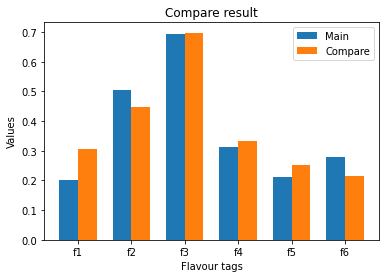

          0         1
0  0.200983  0.216009
1  0.505797  0.474333
2  0.694304  0.673489
3  0.314375  0.478078
4  0.212377  0.151408
5  0.278892  0.152569


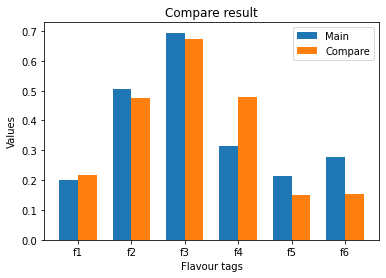

          0         1
0  0.200983  0.177752
1  0.505797  0.500746
2  0.694304  0.659456
3  0.314375  0.401302
4  0.212377  0.264304
5  0.278892  0.227763


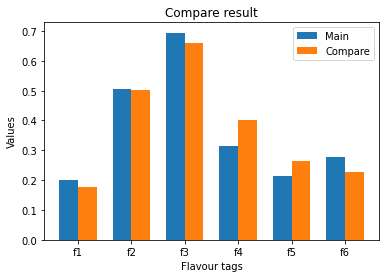

          0         1
0  0.200983  0.149044
1  0.505797  0.330609
2  0.694304  0.749437
3  0.314375  0.400932
4  0.212377  0.260933
5  0.278892  0.279274


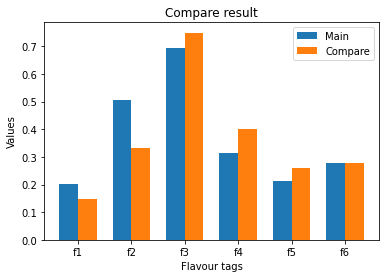

          0         1
0  0.200983  0.229289
1  0.505797  0.502743
2  0.694304  0.663601
3  0.314375  0.323315
4  0.212377  0.269341
5  0.278892  0.277909


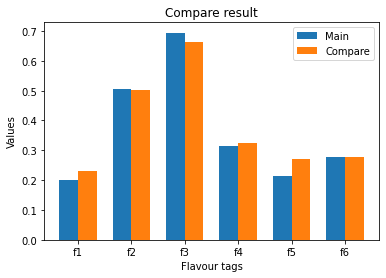

          0         1
0  0.200983  0.157428
1  0.505797  0.455121
2  0.694304  0.718999
3  0.314375  0.391247
4  0.212377  0.206850
5  0.278892  0.235076


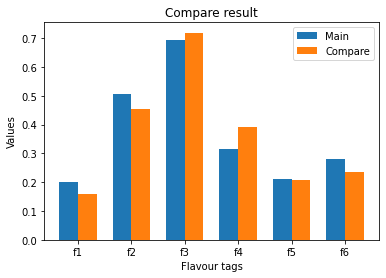

          0         1
0  0.200983  0.073629
1  0.505797  0.396812
2  0.694304  0.706541
3  0.314375  0.499912
4  0.212377  0.221142
5  0.278892  0.197745


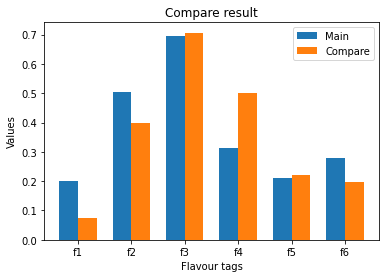

          0         1
0  0.200983  0.200983
1  0.505797  0.505797
2  0.694304  0.694304
3  0.314375  0.314375
4  0.212377  0.212377
5  0.278892  0.278892


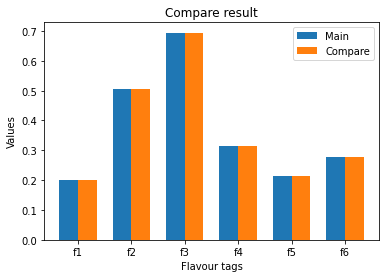

          0         1
0  0.200983  0.200252
1  0.505797  0.399195
2  0.694304  0.689282
3  0.314375  0.423166
4  0.212377  0.326315
5  0.278892  0.199703


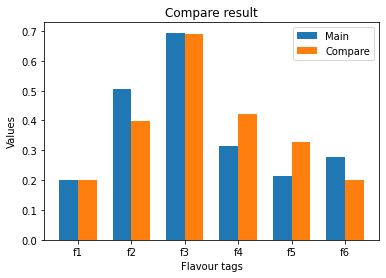

          0         1
0  0.200983  0.190689
1  0.505797  0.379718
2  0.694304  0.735249
3  0.314375  0.409614
4  0.212377  0.187169
5  0.278892  0.275762


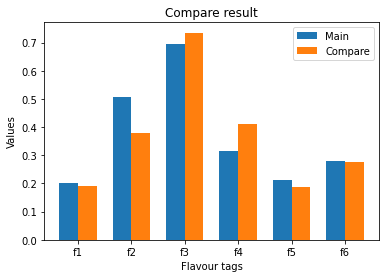

In [168]:
for rs in results:
    liquor_main = df_nan_cleaned.loc[id_entry][FLAVOUR_COLUMNS].values
    plot_results(liquor_main, rs)

## Evaluation

In [171]:
def evaluation(df, liquor_main, list_liquors):
#     entry_data = np.array(df.iloc[id_entry][['score', 'f1', 'f2', 'f3',
#                                              'f4', 'f5', 'f6']])
    mse = 0
    for item in list_liquors:
        e = np.subtract(np.array(item[:6]), liquor_main)
        mse += (e**2)
    
    return mse, np.array(list_liquors).shape[0]

In [195]:
def compute_sum_mse(df, start=0):
    sum_loss = 0
    total_number = 0

    for i in df.index.values:
        list_liquors = find_similar_liquors(df, i)
    #     print(i)
        liquor_main = df[FLAVOUR_COLUMNS].iloc[i].values
        mse, number_liquor = evaluation(df, liquor_main, list_liquors)
        total_number += number_liquor
        sum_loss += mse.sum()

    print('Mean square error ---- {} - start ----- {}'.format(sum_loss, start))
    print('Total number of record ----- {}'.format(total_number))
    print('Mean Loss ----- {}'.format(sum_loss/total_number))
    
    return sum_loss/total_number

In [196]:
compute_sum_mse(df_nan_cleaned)

Mean square error ---- 137.21712779957184 - start ----- 0
Total number of record ----- 6594
Mean Loss ----- 0.02080939153769667


0.02080939153769667

## Find optimal k cluster

In [198]:
def find_optimal_k_value(start, limit):
    sum_mse_values = []
    
    for i in range(start, limit):
        flavour_matrix = df_nan_cleaned.as_matrix(FLAVOUR_COLUMNS)
#         n_clusters = i
        gauss_mixture = GaussianMixture(n_components=i, covariance_type="full").fit(flavour_matrix)
        labels = gauss_mixture.predict(flavour_matrix)
        df_nan_cleaned['clusters'] = labels
        sum_mse_values.append(compute_sum_mse(df_nan_cleaned, start=i))
    
#     print("start----{}".format(start))
    return sum_mse_values

In [199]:
sum_mse_values = find_optimal_k_value(65, 85)

Mean square error ---- 148.3425168424266 - start ----- 65
Total number of record ----- 6807
Mean Loss ----- 0.02179264240376474
Mean square error ---- 149.46453926828727 - start ----- 66
Total number of record ----- 6750
Mean Loss ----- 0.022142894706412928
Mean square error ---- 147.954324624013 - start ----- 67
Total number of record ----- 6855
Mean Loss ----- 0.02158341715886404
Mean square error ---- 148.5901204291845 - start ----- 68
Total number of record ----- 6714
Mean Loss ----- 0.02213138522925
Mean square error ---- 142.90224903077245 - start ----- 69
Total number of record ----- 6777
Mean Loss ----- 0.02108635812760402
Mean square error ---- 147.42684878285345 - start ----- 70
Total number of record ----- 6832
Mean Loss ----- 0.02157887130896567
Mean square error ---- 143.92886961733217 - start ----- 71
Total number of record ----- 6690
Mean Loss ----- 0.021514031332934554
Mean square error ---- 143.28768113425295 - start ----- 72
Total number of record ----- 6742
Mean Loss

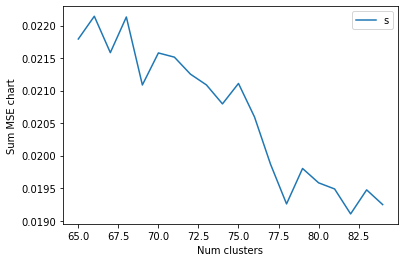

In [200]:
limit=85; start=65; step=6;
x = range(start, limit)
plt.plot(x, sum_mse_values)
plt.xlabel("Num clusters")
plt.ylabel("Sum MSE chart")
plt.legend(("sum_mse_values"), loc='best')
plt.show()